# Predicting Outcomes of Chicago Cubs Games

## Importing Packages

In [44]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from statistics import mean
from itertools import combinations

## The Dataset
For this project I will be building a logistic regression model that tries to correctly predict the outcome of Chicago Cubs games in the 2021 regular season. I will be using variables such as the relative strengths between the Cubs and their current opponents, as well as external factors such as the time of the day in order to try and make these predictions. The datasets for this project all come from https://www.baseball-reference.com/.

Here is a brief description of what each of the columns in this dataset mean:

* Gm# -- Game Number
    Which game out of all played by this team.
* Date -- A number in parentheses indicates which game of a doubleheader.
    Click dates for box scores of games or standings on this day.
* Home or Away Game
    @ means it is an away game, blank means home.
* W/L -- Win/Loss/Tie
    -wo indicates it was a walkoff win or loss. May miss some of those pre-1973, and none before 1940.
* R -- Runs Scored/Allowed
* RA -- Runs Allowed
* Inn -- Innings
    Only shown if something other than 9 innings were played.
* W-L -- Win Loss Record
    Team’s overall record after this game.
* GB -- Games Back of Division/League Leader
    Computed as games over .500 of leader (W-L) minus games over .500 of team divided by two.
    Typically computed at the end of play for a particular day.
    Blank for 1st game of DH.
* Time -- Time of Game
    D/N -- Day or Night Game
    Determined by the start time of the game as stated by RetroSheet.
    We rely on their designation here.
* Attendance -- Attendance
    Typically, tickets sold in home games.
* cLI -- Championship Leverage Index
    The importance of this game on the team's probability of winning the World Series.
    1.0 is average importance, below 1.0 is below average importance and above 1.0 is above average importance.
* Streak -- Win Loss Streak
    plus sign means a winning streak, minus sign means a losing streak.
* Orig. Scheduled -- Originally Scheduled Game Date
    If this is a makeup game, the original game date. The reason for the reschedule is in parentheses.

In [2]:
#read in Cubs dataset
cubs = pd.read_excel(r'C:\Users\njlim2\Desktop\Data Science Projects\MLB Team Schedules\CHC.xlsx')
cubs.head(10)

,Gm#,Date,Column1,Tm,2,Opp,W/L,R,RA,Inn,...,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
0,1,"Thursday, Apr 1",boxscore,CHC,NaN,PIT,L,3,5,NaN,...,1.0,Howard,Hendricks,Rodriguez,4:00,D,"10,343",1.02,-,NaN
1,2,"Saturday, Apr 3",boxscore,CHC,NaN,PIT,W,5,1,NaN,...,Tied,Arrieta,Anderson,NaN,3:08,D,"10,343",1.01,+,NaN
2,3,"Sunday, Apr 4",boxscore,CHC,NaN,PIT,W,4,3,NaN,...,Tied,Davies,Keller,Kimbrel,3:09,D,"10,343",1.10,++,NaN
3,4,"Monday, Apr 5",boxscore,CHC,NaN,MIL,W,5,3,NaN,...,Tied,Williams,Anderson,Mills,2:49,N,"10,343",1.10,+++,NaN
4,5,"Tuesday, Apr 6",boxscore,CHC,NaN,MIL,L,0,4,NaN,...,1.0,Peralta,Alzolay,NaN,3:06,N,"10,343",1.09,-,NaN
5,6,"Wednesday, Apr 7",boxscore,CHC,NaN,MIL,L,2,4,10,...,2.0,Hader,Workman,Boxberger,3:32,D,"10,343",1.10,--,NaN
6,7,"Thursday, Apr 8",boxscore,CHC,@,PIT,W,4,2,NaN,...,1.5,Arrieta,Anderson,Kimbrel,3:15,D,"7,749",1.01,+,NaN
7,8,"Saturday, Apr 10",boxscore,CHC,@,PIT,L,2,8,NaN,...,2.0,Keller,Davies,NaN,3:07,N,"7,052",1.03,-,NaN
8,9,"Sunday, Apr 11",boxscore,CHC,@,PIT,L,1,7,NaN,...,2.0,Brubaker,Williams,NaN,3:02,D,"6,851",1.01,--,NaN
9,10,"Monday, Apr 12",boxscore,CHC,@,MIL,L,3,6,NaN,...,3.0,Peralta,Alzolay,Hader,3:04,N,"11,209",.99,---,NaN


In [3]:
cubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gm#              169 non-null    object
 1   Date             169 non-null    object
 2   Column1          162 non-null    object
 3   Tm               169 non-null    object
 4   2                81 non-null     object
 5   Opp              169 non-null    object
 6   W/L              168 non-null    object
 7   R                168 non-null    object
 8   RA               168 non-null    object
 9   Inn              26 non-null     object
 10  W-L              168 non-null    object
 11  Rank             168 non-null    object
 12  GB               168 non-null    object
 13  Win              168 non-null    object
 14  Loss             168 non-null    object
 15  Save             85 non-null     object
 16  Time             168 non-null    object
 17  D/N              168 non-null    ob

Even though there should only be 162 rows (162 games in a season), there appears to be 169 rows. This is because every 26 rows there is a row that contains the column names. We are only interested in the rows that contain the boxscore, and only need the column names to appear once (in the header row), so we can go ahead and remove these seven rows.

In [4]:
#remove rows with columns names
cubs = cubs[cubs['Column1'] == 'boxscore']
cubs.shape

(162, 22)

Another problem with the datasets occurs in the 'W-L' column. This column contains the W-L record of the team **after** the result of the current game, but we need the the column to contain the record **before** the game starts because in the real world we can't inject any future data into our model. The same thing aplies for the Streak column, so we need to shift the rows in these two columns down by 1.

In [5]:
#shift W-L records down by 1
cubs['W-L'] = cubs['W-L'].shift(1)
cubs.at[0, 'W-L'] = '0-0'
print(cubs['W-L'])
#apply same thing for Streaks
cubs['Streak'] = cubs['Streak'].shift(1)
cubs.at[0, 'Streak'] = ''
print(cubs['Streak'])

0        0-0
1        0-1
2        1-1
3        2-1
4        3-1
       ...  
162    67-90
163    68-90
165    69-90
166    69-91
167    70-91
Name: W-L, Length: 162, dtype: object
0             
1            -
2            +
3           ++
4          +++
        ...   
162    -------
163          +
165         ++
166          -
167          +
Name: Streak, Length: 162, dtype: object


## Merging Datasets
Looking at the columns of the cubs dataset, there seems to be a few columns that could be good predictors of whether or not the cubs will win a particular game (home or away game, day or night game, the current win/loss streak, etc.). However, this dataset provides no information on any of the cubs's opponenets. So in addition to importing the Cubs schedule, we are also going to import the schedules of every team they faced so that we can have data on their opponents and compare the strengths of the two teams for each game. Throughout the 2021 season, they faced a total of 19 different opponents. 

In [6]:
#get list of cubs's opponenets
opponents = cubs['Opp'].unique().tolist()   
print(opponents)

['PIT', 'MIL', 'ATL', 'NYM', 'CIN', 'LAD', 'CLE', 'DET', 'WSN', 'STL', 'SDP', 'SFG', 'MIA', 'PHI', 'ARI', 'COL', 'CHW', 'KCR', 'MIN']


In [7]:
#read in data for all the other teams
for opp in opponents:
    locals()[opp] = pd.read_excel(r'C:\Users\njlim2\Desktop\Data Science Projects\MLB Team Schedules\{}.xlsx'.format(opp))
    #remove rows with column names and shift the 'W-L' and 'Streak' columns down by 1
    locals()[opp] = locals()[opp][locals()[opp]['Column1'] == 'boxscore']
    locals()[opp]['W-L'] = locals()[opp]['W-L'].shift(1)
    locals()[opp].at[0, 'W-L'] = '0-0'
    
    locals()[opp]['Streak'] = locals()[opp]['Streak'].shift(1)
    locals()[opp].at[0, 'Streak'] = ''

We will merge the original cubs dataset with each of the other 19 datasets, with each resulting dataframe containing information (W-L records and Streaks) on both the cubs and their opponent. After that, we will concatenate all the dataframes into one dataframe to mirror the shape of the original dataset (162 rows).

In [8]:
#create dict object that contains all 19 dataframes
df_names = {}
for opp in opponents:
    df = cubs.merge(locals()[opp][['Tm', 'Date', 'W-L', 'Streak']], how='inner', left_on='Opp', right_on='Tm', 
                    suffixes=('_CHC', '_Opp'))
    df = df[df['Date_CHC'] == df['Date_Opp']]
    df_names['CHCvs' + opp] = df
#example dataframe of the cubs and the pirates
df_names['CHCvsPIT']

,Gm#,Date_CHC,Column1,Tm_CHC,2,Opp,W/L,R,RA,Inn,...,Time,D/N,Attendance,cLI,Streak_CHC,Orig. Scheduled,Tm_Opp,Date_Opp,W-L_Opp,Streak_Opp
0,1,"Thursday, Apr 1",boxscore,CHC,NaN,PIT,L,3,5,NaN,...,4:00,D,"10,343",1.02,,NaN,PIT,"Thursday, Apr 1",0-0,
163,2,"Saturday, Apr 3",boxscore,CHC,NaN,PIT,W,5,1,NaN,...,3:08,D,"10,343",1.01,-,NaN,PIT,"Saturday, Apr 3",1-0,+
326,3,"Sunday, Apr 4",boxscore,CHC,NaN,PIT,W,4,3,NaN,...,3:09,D,"10,343",1.10,+,NaN,PIT,"Sunday, Apr 4",1-1,-
492,7,"Thursday, Apr 8",boxscore,CHC,@,PIT,W,4,2,NaN,...,3:15,D,"7,749",1.01,--,NaN,PIT,"Thursday, Apr 8",1-5,-----
655,8,"Saturday, Apr 10",boxscore,CHC,@,PIT,L,2,8,NaN,...,3:07,N,"7,052",1.03,+,NaN,PIT,"Saturday, Apr 10",1-6,------
818,9,"Sunday, Apr 11",boxscore,CHC,@,PIT,L,1,7,NaN,...,3:02,D,"6,851",1.01,-,NaN,PIT,"Sunday, Apr 11",2-6,+
1002,32,"Friday, May 7",boxscore,CHC,NaN,PIT,W,3,2,NaN,...,3:07,D,"10,343",1.02,+++,NaN,PIT,"Friday, May 7",13-17,-
1165,33,"Saturday, May 8",boxscore,CHC,NaN,PIT,W,3,2,NaN,...,3:13,D,"10,343",1.06,++++,NaN,PIT,"Saturday, May 8",13-18,--
1328,34,"Sunday, May 9",boxscore,CHC,NaN,PIT,L,5,6,NaN,...,3:03,D,"10,343",1.09,+++++,NaN,PIT,"Sunday, May 9",13-19,---
1504,47,"Tuesday, May 25",boxscore,CHC,@,PIT,W,4,3,NaN,...,2:59,N,"6,750",1.23,+,NaN,PIT,"Tuesday, May 25",18-28,---


In [9]:
#combine all 19 dataframes to one dataframe
combined_df = pd.DataFrame()
for key in df_names:
    combined_df = pd.concat([combined_df, df_names[key]], axis=0, join='outer')
cubs = combined_df 
cubs

,Gm#,Date_CHC,Column1,Tm_CHC,2,Opp,W/L,R,RA,Inn,...,Time,D/N,Attendance,cLI,Streak_CHC,Orig. Scheduled,Tm_Opp,Date_Opp,W-L_Opp,Streak_Opp
0,1,"Thursday, Apr 1",boxscore,CHC,NaN,PIT,L,3,5,NaN,...,4:00,D,"10,343",1.02,,NaN,PIT,"Thursday, Apr 1",0-0,
163,2,"Saturday, Apr 3",boxscore,CHC,NaN,PIT,W,5,1,NaN,...,3:08,D,"10,343",1.01,-,NaN,PIT,"Saturday, Apr 3",1-0,+
326,3,"Sunday, Apr 4",boxscore,CHC,NaN,PIT,W,4,3,NaN,...,3:09,D,"10,343",1.10,+,NaN,PIT,"Sunday, Apr 4",1-1,-
492,7,"Thursday, Apr 8",boxscore,CHC,@,PIT,W,4,2,NaN,...,3:15,D,"7,749",1.01,--,NaN,PIT,"Thursday, Apr 8",1-5,-----
655,8,"Saturday, Apr 10",boxscore,CHC,@,PIT,L,2,8,NaN,...,3:07,N,"7,052",1.03,+,NaN,PIT,"Saturday, Apr 10",1-6,------
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,126,"Sunday, Aug 22",boxscore,CHC,NaN,KCR,L,1,9,NaN,...,3:25,D,"29,640",.00,--,NaN,KCR,"Sunday, Aug 22",54-68,++
131,133,"Tuesday, Aug 31",boxscore,CHC,@,MIN,W,3,1,NaN,...,3:34,N,"22,224",.00,-,NaN,MIN,"Tuesday, Aug 31",58-73,+
294,134,"Wednesday, Sep 1",boxscore,CHC,@,MIN,W,3,0,NaN,...,2:28,N,"21,784",.00,+,NaN,MIN,"Wednesday, Sep 1",58-74,-
474,151,"Tuesday, Sep 21",boxscore,CHC,NaN,MIN,L,5,9,NaN,...,4:05,N,"25,594",.00,+,NaN,MIN,"Tuesday, Sep 21",65-85,--


In [10]:
#reorder rows by game number
cubs['Gm#'] = pd.to_numeric(cubs['Gm#'])
cubs = cubs.sort_values(by='Gm#')
cubs.reset_index(drop=True, inplace=True)
cubs

,Gm#,Date_CHC,Column1,Tm_CHC,2,Opp,W/L,R,RA,Inn,...,Time,D/N,Attendance,cLI,Streak_CHC,Orig. Scheduled,Tm_Opp,Date_Opp,W-L_Opp,Streak_Opp
0,1,"Thursday, Apr 1",boxscore,CHC,NaN,PIT,L,3,5,NaN,...,4:00,D,"10,343",1.02,,NaN,PIT,"Thursday, Apr 1",0-0,
1,2,"Saturday, Apr 3",boxscore,CHC,NaN,PIT,W,5,1,NaN,...,3:08,D,"10,343",1.01,-,NaN,PIT,"Saturday, Apr 3",1-0,+
2,3,"Sunday, Apr 4",boxscore,CHC,NaN,PIT,W,4,3,NaN,...,3:09,D,"10,343",1.10,+,NaN,PIT,"Sunday, Apr 4",1-1,-
3,4,"Monday, Apr 5",boxscore,CHC,NaN,MIL,W,5,3,NaN,...,2:49,N,"10,343",1.10,++,NaN,MIL,"Monday, Apr 5",1-2,--
4,5,"Tuesday, Apr 6",boxscore,CHC,NaN,MIL,L,0,4,NaN,...,3:06,N,"10,343",1.09,+++,NaN,MIL,"Tuesday, Apr 6",1-3,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,158,"Wednesday, Sep 29",boxscore,CHC,@,PIT,W,3,2,NaN,...,3:44,N,"9,236",.00,-------,NaN,PIT,"Wednesday, Sep 29",59-98,+
158,159,"Thursday, Sep 30",boxscore,CHC,@,PIT,W,9,0,NaN,...,2:49,N,"10,152",.00,+,NaN,PIT,"Thursday, Sep 30",59-99,-
159,160,"Friday, Oct 1",boxscore,CHC,@,STL,L-wo,3,4,NaN,...,3:25,N,"41,618",.00,++,NaN,STL,"Friday, Oct 1",89-70,+
160,161,"Saturday, Oct 2",boxscore,CHC,@,STL,W,6,5,NaN,...,3:25,N,"45,239",.00,-,NaN,STL,"Saturday, Oct 2",90-70,++


## Cleaning the Dataset
Now that we have successfully inputed data on each of the opponents into the dataset, it is now time to do some cleaning. First, we will drop any columns that don't provide any meaningful information or are unnecessary for our model. The columns we will need for our logistic regression model are the W-L records and streaks for both the cubs and their opponent, as well as the home/away column, the day/night column, and the cLI column, which measures the relative importance of the game. We can go ahead and drop all the other columns.

In [11]:
#drop unneccessary columns
drop_cols = ['Column1', 'R', 'RA', 'Inn', 'Rank', 'GB', 'Win', 'Loss', 'Save', 'Time', 'Attendance', 'Orig. Scheduled',
            'Tm_Opp', 'Date_Opp']
cubs.drop(drop_cols, axis=1, inplace=True)
cubs.head(10)

,Gm#,Date_CHC,Tm_CHC,2,Opp,W/L,W-L_CHC,D/N,cLI,Streak_CHC,W-L_Opp,Streak_Opp
0,1,"Thursday, Apr 1",CHC,NaN,PIT,L,0-0,D,1.02,,0-0,
1,2,"Saturday, Apr 3",CHC,NaN,PIT,W,0-1,D,1.01,-,1-0,+
2,3,"Sunday, Apr 4",CHC,NaN,PIT,W,1-1,D,1.10,+,1-1,-
3,4,"Monday, Apr 5",CHC,NaN,MIL,W,2-1,N,1.10,++,1-2,--
4,5,"Tuesday, Apr 6",CHC,NaN,MIL,L,3-1,N,1.09,+++,1-3,---
5,6,"Wednesday, Apr 7",CHC,NaN,MIL,L,3-2,D,1.10,-,2-3,+
6,7,"Thursday, Apr 8",CHC,@,PIT,W,3-3,D,1.01,--,1-5,-----
7,8,"Saturday, Apr 10",CHC,@,PIT,L,4-3,N,1.03,+,1-6,------
8,9,"Sunday, Apr 11",CHC,@,PIT,L,4-4,D,1.01,-,2-6,+
9,10,"Monday, Apr 12",CHC,@,MIL,L,4-5,N,.99,--,5-4,++


Looking at the above dataframe, the '2' (home/away) column and the 'D/N' column need to be updated so that the categories are represented by 0's and 1's. We also need to create columns that measure the difference in the wins and streaks between the cubs and their opponenets. For wins, we will measure who has currently has more wins, as well as the difference between both the **number** of wins and the win **percentage**. For streaks, we will measure who has the better streak and the difference between the two teams' streaks.

In [12]:
#update home/away column
def home_or_away(x):
    if x == '@':
        return 0
    else:
        return 1
cubs['2'] = cubs['2'].apply(home_or_away)
cubs.rename(columns={'2' : 'H/A'}, inplace=True)

#update day/night column
def day_or_night(x):
    if x == 'D':
        return 1
    else:
        return 0
cubs['D/N'] = cubs['D/N'].apply(day_or_night)

In [13]:
#create columns containing difference in number/percentage of wins between the two teams
def more_wins(x):
    if int(x['W-L_CHC'].split('-')[0]) > int(x['W-L_Opp'].split('-')[0]):
        return 1
    else:
        return 0
    
def win_diff(x):
    return int(x['W-L_CHC'].split('-')[0]) - int(x['W-L_Opp'].split('-')[0])

def win_per_diff(x):
    cubs_total_games = int(x['W-L_CHC'].split('-')[0]) + int(x['W-L_CHC'].split('-')[1])
    opp_total_games = int(x['W-L_Opp'].split('-')[0]) + int(x['W-L_Opp'].split('-')[1])
    if cubs_total_games == 0:
        cubs_total_games += 1
    if opp_total_games == 0:
        opp_total_games += 1   
    cubs_win_per = int(x['W-L_CHC'].split('-')[0]) / cubs_total_games
    opp_win_per = int(x['W-L_Opp'].split('-')[0]) / opp_total_games
    return cubs_win_per - opp_win_per

cubs['Better_team'] = cubs.apply (lambda x: more_wins(x), axis=1)
cubs['W-L_diff'] = cubs.apply (lambda x: win_diff(x), axis=1)
cubs['W-L_per_diff'] = cubs.apply (lambda x: win_per_diff(x), axis=1)

#create column containing difference in the streaks between the two teams
def higher_streak(x):
    if x['Streak_CHC'] == '':
        cubs_streak = 0
    if x['Streak_CHC'].startswith('-'):
        cubs_streak = -len(x['Streak_CHC'])
    elif x['Streak_CHC'].startswith('+'):
        cubs_streak = len(x['Streak_CHC'])
    if x['Streak_Opp'] == '':
        opp_streak = 0
    if x['Streak_Opp'].startswith('-'):
        opp_streak = -len(x['Streak_Opp'])
    elif x['Streak_Opp'].startswith('+'):
        opp_streak = len(x['Streak_Opp'])
    if cubs_streak > opp_streak:
        return 1
    else:
        return 0
    
def streak_diff(x):
    if x['Streak_CHC'] == '':
        cubs_streak = 0
    if x['Streak_CHC'].startswith('-'):
        cubs_streak = -len(x['Streak_CHC'])
    elif x['Streak_CHC'].startswith('+'):
        cubs_streak = len(x['Streak_CHC'])
    if x['Streak_Opp'] == '':
        opp_streak = 0
    if x['Streak_Opp'].startswith('-'):
        opp_streak = -len(x['Streak_Opp'])
    elif x['Streak_Opp'].startswith('+'):
        opp_streak = len(x['Streak_Opp'])
    return cubs_streak - opp_streak

cubs['Hotter_team'] = cubs.apply (lambda x: higher_streak(x), axis=1)
cubs['Streak_diff'] = cubs.apply (lambda x: streak_diff(x), axis=1)

Our target variable (whether or not the cubs win the game) also needs to be represented by 0's and 1's.

In [14]:
#update win/loss column
def win_or_loss(x):
    if x.startswith('W'):
        return 1
    else:
        return 0
cubs['Win/Loss'] = cubs['W/L'].apply(win_or_loss)
cubs.drop(labels='W/L', axis=1, inplace=True)

In [15]:
#finalized dataframe
cubs.head(20)

,Gm#,Date_CHC,Tm_CHC,H/A,Opp,W-L_CHC,D/N,cLI,Streak_CHC,W-L_Opp,Streak_Opp,Better_team,W-L_diff,W-L_per_diff,Hotter_team,Streak_diff,Win/Loss
0,1,"Thursday, Apr 1",CHC,1,PIT,0-0,1,1.02,,0-0,,0,0,0.000000,0,0,0
1,2,"Saturday, Apr 3",CHC,1,PIT,0-1,1,1.01,-,1-0,+,0,-1,-1.000000,0,-2,1
2,3,"Sunday, Apr 4",CHC,1,PIT,1-1,1,1.10,+,1-1,-,0,0,0.000000,1,2,1
3,4,"Monday, Apr 5",CHC,1,MIL,2-1,0,1.10,++,1-2,--,1,1,0.333333,1,4,1
4,5,"Tuesday, Apr 6",CHC,1,MIL,3-1,0,1.09,+++,1-3,---,1,2,0.500000,1,6,0
5,6,"Wednesday, Apr 7",CHC,1,MIL,3-2,1,1.10,-,2-3,+,1,1,0.200000,0,-2,0
6,7,"Thursday, Apr 8",CHC,0,PIT,3-3,1,1.01,--,1-5,-----,1,2,0.333333,1,3,1
7,8,"Saturday, Apr 10",CHC,0,PIT,4-3,0,1.03,+,1-6,------,1,3,0.428571,1,7,0
8,9,"Sunday, Apr 11",CHC,0,PIT,4-4,1,1.01,-,2-6,+,1,2,0.250000,0,-2,0
9,10,"Monday, Apr 12",CHC,0,MIL,4-5,0,.99,--,5-4,++,0,-1,-0.111111,0,-4,0


In [16]:
cubs['Win/Loss'].value_counts()

0    91
1    71
Name: Win/Loss, dtype: int64

## Train and Test Splits
Now it's time to split our data into a train dataset and a test dataset. There are many different ratios we can use to split our data into a train and test set. For this project, we will use the 75:25 ratio. First, we will check to make sure there are no null values present in our data.

In [17]:
#check if any null values are present
cubs.isnull().sum()

Gm#             0
Date_CHC        0
Tm_CHC          0
H/A             0
Opp             0
W-L_CHC         0
D/N             0
cLI             0
Streak_CHC      0
W-L_Opp         0
Streak_Opp      0
Better_team     0
W-L_diff        0
W-L_per_diff    0
Hotter_team     0
Streak_diff     0
Win/Loss        0
dtype: int64

In [18]:
#split dataset into a train and test set
predictors = ['H/A', 'D/N', 'cLI', 'W-L_diff', 'W-L_per_diff', 'Streak_diff', 'Better_team', 'Hotter_team']
X = cubs[predictors]
y = cubs['Win/Loss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.head(10)

,H/A,D/N,cLI,W-L_diff,W-L_per_diff,Streak_diff,Better_team,Hotter_team
22,0,0,.85,0,0.000000,-4,0,0
95,0,0,.71,0,0.000000,2,0,1
71,1,1,1.41,8,0.112676,-4,1,0
113,1,1,.05,-14,-0.129109,-2,0,0
144,0,0,.00,-7,-0.052108,-2,0,0
101,1,0,.65,-1,-0.014950,4,0,1
27,0,1,.86,0,-0.017094,2,0,1
120,0,0,.00,-12,-0.104482,-12,0,0
85,1,0,.67,2,0.006313,-11,1,0
55,0,0,1.43,-2,-0.036364,4,0,1


In [19]:
X_train.describe()

,H/A,D/N,W-L_diff,W-L_per_diff,Streak_diff,Better_team,Hotter_team
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.528926,0.429752,-1.388430,-0.012511,-1.776860,0.413223,0.363636
std,0.501238,0.497099,8.999418,0.146252,5.752518,0.494460,0.483046
min,0.000000,0.000000,-27.000000,-1.000000,-20.000000,0.000000,0.000000
25%,0.000000,0.000000,-4.000000,-0.081720,-5.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,-0.014881,-2.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000,0.042735,3.000000,1.000000,1.000000
max,1.000000,1.000000,20.000000,0.500000,9.000000,1.000000,1.000000


In [20]:
X_test.head(10)

,H/A,D/N,cLI,W-L_diff,W-L_per_diff,Streak_diff,Better_team,Hotter_team
66,0,0,1.47,4,-0.000514,-2,1,0
131,0,1,.00,-18,-0.137405,2,0,1
145,0,0,.00,-6,-0.044828,3,0,1
7,0,0,1.03,3,0.428571,7,1,1
44,0,0,1.45,-2,-0.045455,3,0,1
74,0,0,1.54,-3,-0.040541,4,0,1
124,1,1,.00,1,-0.002533,-2,1,0
159,0,0,.00,-20,-0.125786,1,0,1
86,1,0,.58,1,-0.005604,-13,1,0
122,0,1,.00,-12,-0.102764,2,0,1


## Model Training/Checking Accuracy
Now it's time to instantiate/train our machine learning model. As mentioned above, the variables we will be using are the W-L records of both teams, the streaks of both teams, home/away, day/night, and the cLI. Below is 
- *W-L records* help us compare the relative strengths of the two teams. The team with the better record heading into the matchup should be favored to win. We have three ways of comparing the W-L records: who has more wins (better team), the difference in number of wins, and the difference in win percentage. These three metrics each have their pros and cons. We will determine the best metric(s) to use when we do variable selection.
    - The difference in wins metric doesn't put enough emphasis on early games. For example, two teams can have the records 10-0 and 0-10, and another two teams can have the records 50-40 and 40-50. Even though in both cases there is a 10 win difference, the difference in strength between the first two teams is intuitevly larger because of their win percentages.
    - The difference in win percentage metric however puts too much emphasis on early games. If two teams are 1-0 and 0-1, the difference is 100 percent. This implies a large gap between the two teams, when in reality both teams have only played one game.
    - The who has more wins metric is just a very general way of determining who is the better team, but it doesn't measure how much better one team is over the other.
- *Streaks* tells us how hot or cold a team currently is. Even though one team might have a worse W-L record, if that team is on a huge win streak their chances of winning the game increases.
    - Our two metrics for comparing streaks is the difference between the win/loss streaks, and a more general metric of just who has the higher win streak (the hotter team).
- *Home vs. Away* is a useful variable to help predict the outcome of the game. Each MLB stadium is different and has their unique perks, so playing at your own stadium should theoretically be an advantage for the home team.
- *cLI* is also useful since it tells us how important a particular game is. If a certain team does well under pressure, then they should perform better if the cLI is high, and vica versa if a team chokes under pressure.
- *Day vs. Night* tells us at what time the game was played. Intuitively the time of day shouldn't really effect performance, but maybe certain teams play better during the daytime or nighttime.

In [21]:
#create and train model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [22]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
print(predictions_test)

[0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0
 0 0 1 1]


In [23]:
#predict_proba method gives the probabilities for the target variable(0 and 1).
predict_prob = model.predict_proba(X_test)
predict_prob_df = pd.DataFrame(data=predict_prob, columns=['Prob of Loss (0)', 'Prob of Win (1)'])
predict_prob_df.head(10)
#For example, in the first row in the dataframe below, our model says there is a 56.71 percent chance of a
#loss for the cubs. Since our threshold value is 0.5 (default threshold), our model would predict a loss.

,Prob of Loss (0),Prob of Win (1)
0,0.567135,0.432865
1,0.723062,0.276938
2,0.608139,0.391861
3,0.482174,0.517826
4,0.620760,0.379240
5,0.613265,0.386735
6,0.422912,0.577088
7,0.809420,0.190580
8,0.781433,0.218567
9,0.650927,0.349073


To check our model's accuracy, we will use the accuracy_score function. 

In [24]:
#accuracy score on train set
train_score = accuracy_score(y_train, predictions_train)
print('Train set score: ' + str(train_score))

Train set score: 0.6528925619834711


In [25]:
#accuracy score on test set
test_score = accuracy_score(y_test, predictions_test)
print('Test set score: ' + str(test_score))

Test set score: 0.43902439024390244


As seen above, our accuracy score on the train set was a lot higher than on the test set. When this happens, there is likely a case of overfitting. This makes sense because some of our predictor variables are highly correlated (multicollinearity), and multicollinearity is one of many causes of overfitting. This problem should go away once we remove some of the variables when we perform variable selection.

### Cross Validation
For the model above, we used the train-test split method where the first 75 percent of our data was assigned to the train set and the other 25 percent to the test set. However a much preferred method is k-fold cross validation. The reason it is preferred is because it allows our model to train on multiple train-test splits, which makes the model less biased. We will use 4 splits for our cross validation model. 

In [26]:
#create cv model
X = cubs[predictors]
y = cubs['Win/Loss']
kf = KFold(n_splits=4, shuffle=True, random_state=0)
score = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print('Cross Validation Score: ' + str(score.mean()))

Cross Validation Score: 0.5501524390243901


To make our cross validation score more accurate, we will compute the cross validation score across 5 different random states, and then take the average of the 5 cv scores as our final cv score.

In [27]:
acc_scores_list = []
for i in range(0, 5):
    kf = KFold(n_splits=4, shuffle=True, random_state=i)
    score = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    acc_scores_list.append(score)
acc_scores_list

[array([0.43902439, 0.53658537, 0.525     , 0.7       ]),
 array([0.68292683, 0.56097561, 0.6       , 0.5       ]),
 array([0.63414634, 0.63414634, 0.575     , 0.525     ]),
 array([0.51219512, 0.53658537, 0.55      , 0.55      ]),
 array([0.53658537, 0.53658537, 0.675     , 0.625     ])]

In [28]:
#compute average cv score scross the five random states
sum_scores = 0
for array in acc_scores_list:
    for score in array:
        sum_scores += score
average_score = sum_scores / 20
print('Average Cross Validation Score: ' + str(average_score))

Average Cross Validation Score: 0.5717378048780489


### Variable Selection
Our accuracy score for the model using all the variables turned out to be roughly 57 percent. We will see if we can increase this accuracy score by removing some unneccessary variables.

In [29]:
#create acc_score calculator
def compute_acc_score(predictors):
    X = cubs[predictors]
    y = cubs['Win/Loss']
    acc_scores_list = []
    for i in range(0, 5):
        kf = KFold(n_splits=4, shuffle=True, random_state=i)
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        acc_scores_list.append(scores)
    sum_scores = 0
    for array in acc_scores_list:
        for score in array:
            sum_scores += score
    average_score = sum_scores / 20
    return average_score

In [30]:
acc_score_dict = {}
predictors = X_train.columns

#compute accuracy score for all possible models        
for i in range(1, len(predictors) + 1):        
    for comb in combinations(predictors, i):
        comb_list = list(comb)
        acc_score = compute_acc_score(comb_list)
        acc_score_dict[tuple(comb_list)] = acc_score

#sort the dict from highest to lowest accuracy
sorted_acc_score_dict = {k: v for k, v in sorted(acc_score_dict.items(), key=lambda item: item[1], reverse=True)}
#only print the first 10 items
{k: sorted_acc_score_dict[k] for k in list(sorted_acc_score_dict)[:10]}

{('H/A', 'cLI', 'W-L_diff', 'W-L_per_diff', 'Hotter_team'): 0.6053048780487805,
 ('H/A',
  'W-L_diff',
  'W-L_per_diff',
  'Better_team',
  'Hotter_team'): 0.6052134146341464,
 ('H/A', 'cLI', 'W-L_diff', 'Better_team', 'Hotter_team'): 0.6028048780487805,
 ('H/A',
  'cLI',
  'W-L_diff',
  'W-L_per_diff',
  'Better_team',
  'Hotter_team'): 0.6027134146341464,
 ('H/A', 'cLI', 'W-L_diff', 'W-L_per_diff'): 0.5991768292682926,
 ('H/A', 'W-L_diff', 'Better_team', 'Hotter_team'): 0.5978353658536586,
 ('H/A', 'W-L_diff', 'Streak_diff', 'Better_team'): 0.5951219512195121,
 ('H/A', 'W-L_diff', 'W-L_per_diff', 'Hotter_team'): 0.5941768292682926,
 ('H/A', 'cLI', 'W-L_per_diff', 'Streak_diff'): 0.5941158536585365,
 ('H/A', 'cLI', 'W-L_diff', 'Streak_diff', 'Better_team'): 0.5940548780487804}

After computing the accuracy score for all possible models, the model that ended up with the highest accuracy score (60.5 percent) included the variables 'H/A', 'cLI', 'W-L_diff', 'W-L_per_diff', and 'Hotter_team'. We will go ahead and conclude that this is the best model.

### Confusion Matrix
A confusion matrix is a useful matrix that describes the performance of a classification model. It gives us a summary of correct and incorrect predicitons broken down by each category (true positives, true negatives, false positives, false negatives).

In [58]:
#create confusion matrix using our best model
new_predictors = ['H/A', 'cLI', 'W-L_diff', 'W-L_per_diff', 'Hotter_team']
X = cubs[new_predictors]
y = cubs['Win/Loss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
new_model = LogisticRegression()
new_model.fit(X_train, y_train)
y_predictions = new_model.predict(X_test)
matrix = confusion_matrix(y_test, y_predictions)
print('Confusion matrix\n\n', matrix)

Confusion matrix

 [[16 10]
 [ 4 11]]


In [59]:
#create classification report
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70        26
           1       0.52      0.73      0.61        15

    accuracy                           0.66        41
   macro avg       0.66      0.67      0.65        41
weighted avg       0.70      0.66      0.66        41



### ROC Curve


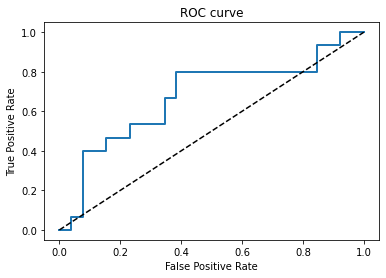

In [63]:
y_pred1 = new_model.predict_proba(X_test)[:, 1]
#create ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
#compute ROC AUC (area under curve)
roc_auc = roc_auc_score(y_test, y_pred1)
print(roc_auc)

0.6743589743589744


## Summary
Our best logisitc regression model ended up with an accuracy score of 60.5 percent. Although this may seem like a low accuracy score, it is in general very difficult to make predicitons in the sports world due to the high volatility present in each game. Most online sports betting sites have an accuracy score that hovers around 60 percent, so considering that, our model proved to be pretty effective. However for this project we only used a 162 sample size, so our model didn't have that much data to train on. To make our accuracy score more realistic and reliable, we should train our model across multiple seasons and teams.